In [1]:
import numpy as np
from pysrc.optimization import gams, gurobi
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data
from pysrc.analysis import value_decomposition

/Users/ph2696/Projects/project-amazon/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model scenario

In [6]:
opt = "gurobi"
pee = 7.1
pa = 41.11
b = 25
sitenum = 78
T = 200
h = 0

## Solve model

In [7]:
# Load site data
(
    zbar_2017,
    z_2017,
    forest_area_2017,
    _,
    _,
    _,
    _,
) = load_site_data(sitenum)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    model_name="full_model",
    num_sites=sitenum,
    iter_sampling=10**4,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x0_vals = gamma * forest_area_2017

# Choose optimizer
if opt == "gurobi":
    solve_planner_problem = gurobi.solve_planner_problem

elif opt == "gams":
    solve_planner_problem = gams.solve_planner_problem

else:
    raise ValueError("Optimizer must be one of ['gurobi', 'gams']")

results = solve_planner_problem(
    T=T + h,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + b,
    pa=pa,
)

Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


10:44:42 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


10:44:49 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_models/full_model/baseline
10:44:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▌         | 00:00 Iteration:  400 / 10000 [  4%]  (Sampling)







chain 1 |█▏        | 00:00 Iteration: 1100 / 10000 [ 11%]  (Sampling)






chain 1 |█▊        | 00:00 Iteration: 1800 / 10000 [ 18%]  (Sampling)







chain 1 |██▍       | 00:00 Iteration: 2500 / 10000 [ 25%]  (Sampling)





chain 1 |██▉       | 00:00 Iteration: 3100 / 10000 [ 31%]  (Sampling)





chain 1 |███▍      | 00:00 Iteration: 3700 / 10000 [ 37%]  (Sampling)





chain 1 |████      | 00:00 Iteration: 4300 / 10000 [ 43%]  (Sampling)





chain 1 |████▌     | 00:00 Iteration: 4900 / 10000 [ 49%]  (Sampling)





chain 1 |█████     | 00:01 Iteration: 5500 / 10000 [ 55%]  (Sampling)





chain 1 |█████▋    | 00:01 Iteration: 6100 / 10000 [ 61%]  (Sampling)





chain 1 |██████    | 00


10:44:52 - cmdstanpy - INFO - CmdStan done processing.



Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmpppuna_4m.pyomo.lp
Reading time = 0.12 seconds
x1: 31400 rows, 62601 columns, 155966 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31400 rows, 62601 columns and 155966 nonzeros
Model fingerprint: 0xfadd2b57
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-02, 6e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 15602 rows and 15604 columns
Presolve time: 0.03s
Presolved: 15798 rows, 46997 columns, 93715 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.01s

Barrier stat

In [12]:
results["w"].shape

(201,)

In [4]:
value_decomposition(
    Z=results["Z"],
    X=results["X"],
    U=results["U"],
    V=results["V"],
    T=T+h,
    pee=pee,
    pa=pa,
    b=b,
    theta=theta,
)

{'pa': 41.11,
 'pee': 7.1,
 'b': 25,
 'total_AO': 17.401962135381787,
 'total_NT': 352.80105967310476,
 'total_FS': 100.19550094716173,
 'total_AC': 26.96575573223418,
 'total_PV': 443.4327670234141}

In [5]:
V = [
    value_decomposition(
        Z=results["Z"][t:],
        X=results["X"][t:],
        U=results["U"][t:],
        V=results["V"][t:],
        T=T,
        pee=pee,
        pa=pa,
        b=b,
        theta=theta,
    )["total_PV"]
    for t in range(h)
]

<function matplotlib.pyplot.show(close=None, block=None)>

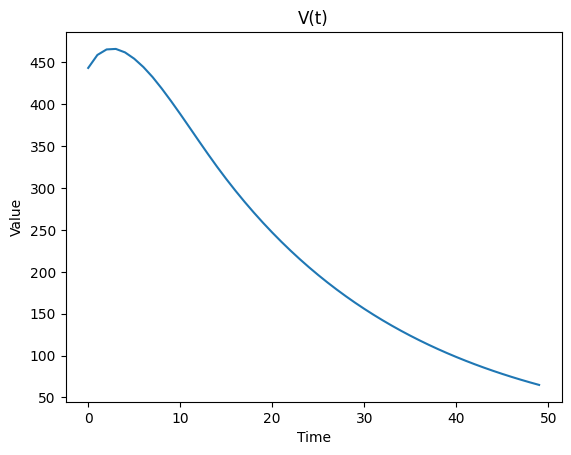

In [6]:
import matplotlib.pyplot as plt

# Plotting the line plot
plt.plot(V)

# Adding labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("V(t)")

# Displaying the plot
plt.show

In [7]:
W = []
for t in range(h):
    defection = solve_planner_problem(
        T=T,
        theta=theta,
        gamma=gamma,
        x0=results["X"][t],
        zbar=zbar_2017,
        z0=results["Z"][t],
        pe=pee,
        pa=pa,
    )

    W.append(
        value_decomposition(
            Z=defection["Z"],
            X=defection["X"],
            U=defection["U"],
            V=defection["V"],
            T=T,
            pee=pee,
            pa=pa,
            b=0,
            theta=theta,
        )["total_PV"]
    )

Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmpcn71j71h.pyomo.lp
Reading time = 0.08 seconds
x1: 31400 rows, 62601 columns, 155966 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31400 rows, 62601 columns and 155966 nonzeros
Model fingerprint: 0x54b2818a
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-03, 1e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 15602 rows and 15604 columns
Presolve time: 0.02s
Presolved: 15798 rows, 46997 columns, 93715 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.00s

Barrier stati

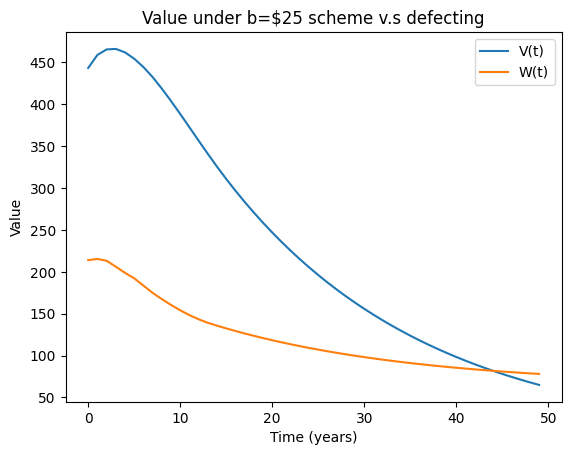

In [8]:
# Plotting the line plots for V and W
plt.plot(V, label="V(t)")
plt.plot(W, label="W(t)")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Value under b=$25 scheme v.s defecting")

# Displaying the plot
plt.show()

## Time and value of defecting

In [9]:
def defect_time(V, W):
    indices = [i for i, (v, w) in enumerate(zip(V, W)) if v < w]
    return indices[0] if indices else -1

In [10]:
defect_time(V, W)

44

## Maximum gap between $V(t)$ and $W(t)$

In [11]:
abs(min([V[i] - W[i] for i in range(h)]))

13.10818911429007

In [12]:
abs(min([V[i] - W[i] for i in range(h)])) / (1.02 ** (h))

4.870057740151881

In [18]:
[(V[i] - W[i])/ (1.02 ** i) for i in range(h)]

[229.50275051222533,
 238.8042188622355,
 242.56289845093036,
 245.02375163371408,
 243.16615958092683,
 237.49709002722489,
 231.69963253623885,
 224.2760735270284,
 214.49855577868297,
 203.68704055027715,
 192.31767746295066,
 180.39061856935237,
 168.16857675841067,
 155.9747679616359,
 143.86157705694177,
 132.56299100025367,
 122.02625756956901,
 112.20200292141483,
 103.04401599990285,
 94.50904664873677,
 86.55661659625886,
 79.1488424929936,
 72.25027023342345,
 65.82771984271898,
 59.85014025496123,
 54.2884733523465,
 49.11552667502397,
 44.305854248863454,
 39.83564501366615,
 35.68261836731871,
 31.82592637227073,
 28.246062199628614,
 24.92477441322689,
 21.84498672138212,
 18.990722847772798,
 16.347036195086204,
 13.899943995895093,
 11.636365664689176,
 9.54406508322255,
 7.611596568413681,
 5.828254288014137,
 4.184024904230418,
 2.6695432394876786,
 1.2760507716572698,
 -0.004643221669938795,
 -1.1801980387608928,
 -2.2577756073141457,
 -3.2440723640898907,
 -4.14534

## Analysing gap

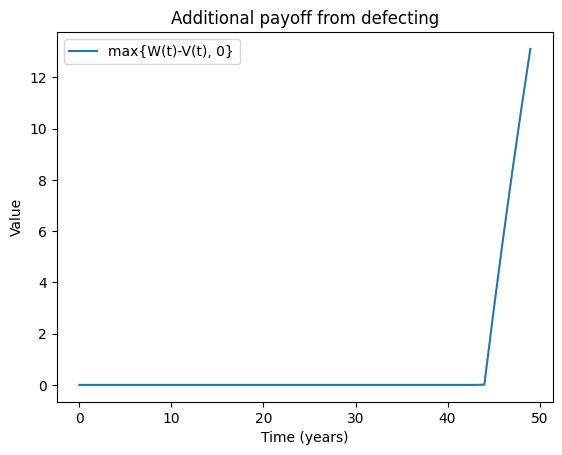

In [13]:
gap = [max(W[i] - V[i], 0) for i in range(h)]

# Plotting the line plots for V and W
plt.plot(gap, label="max{W(t)-V(t), 0}")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Additional payoff from defecting")

# Displaying the plot
plt.show()

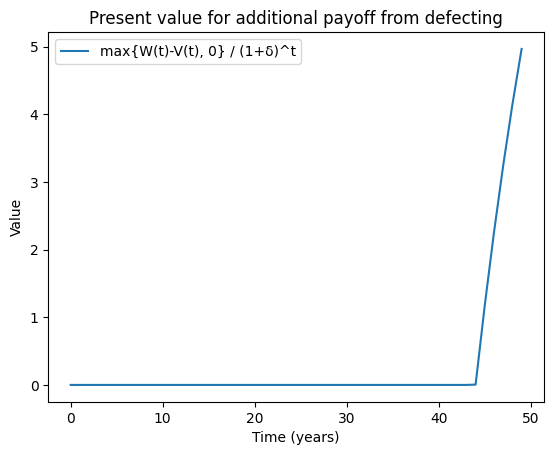

In [14]:
PV_gap = [max(W[t] - V[t], 0) / (1.02 ** (t)) for t in range(h)]

# Plotting the line plots for V and W
plt.plot(PV_gap, label="max{W(t)-V(t), 0} / (1+δ)^t")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Present value for additional payoff from defecting")

# Displaying the plot
plt.show()

In [16]:
PV_gap[49]

4.967458894954919